https://www.kaggle.com/code/kaunal11/kunal-titanic/notebook

In [6]:
!pip install catboost

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's ignore warnings for now
import warnings
warnings.filterwarnings('ignore')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading in the data

In [11]:
import os
os.chdir('/content/drive/MyDrive/Projects/titanic')

# Import Train and Test Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [12]:
# View the Training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
# View the Test data
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [14]:
# View the Gender Submission data
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


#Data Descriptions
---
Survival: 0 = No, 1 = Yes

pclass (Ticket class): 1 = 1st, 2 = 2nd, 3 = 3rd

sex: Sex

Age: Age in years

sibsp: number of siblings/spouses aboard the Titanic

parch: number of parents/children aboard the Titanic

ticket: Ticket number

fare: Passenger fare

cabin: Cabin number

embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [15]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
train.dtypes

,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


<Axes: >

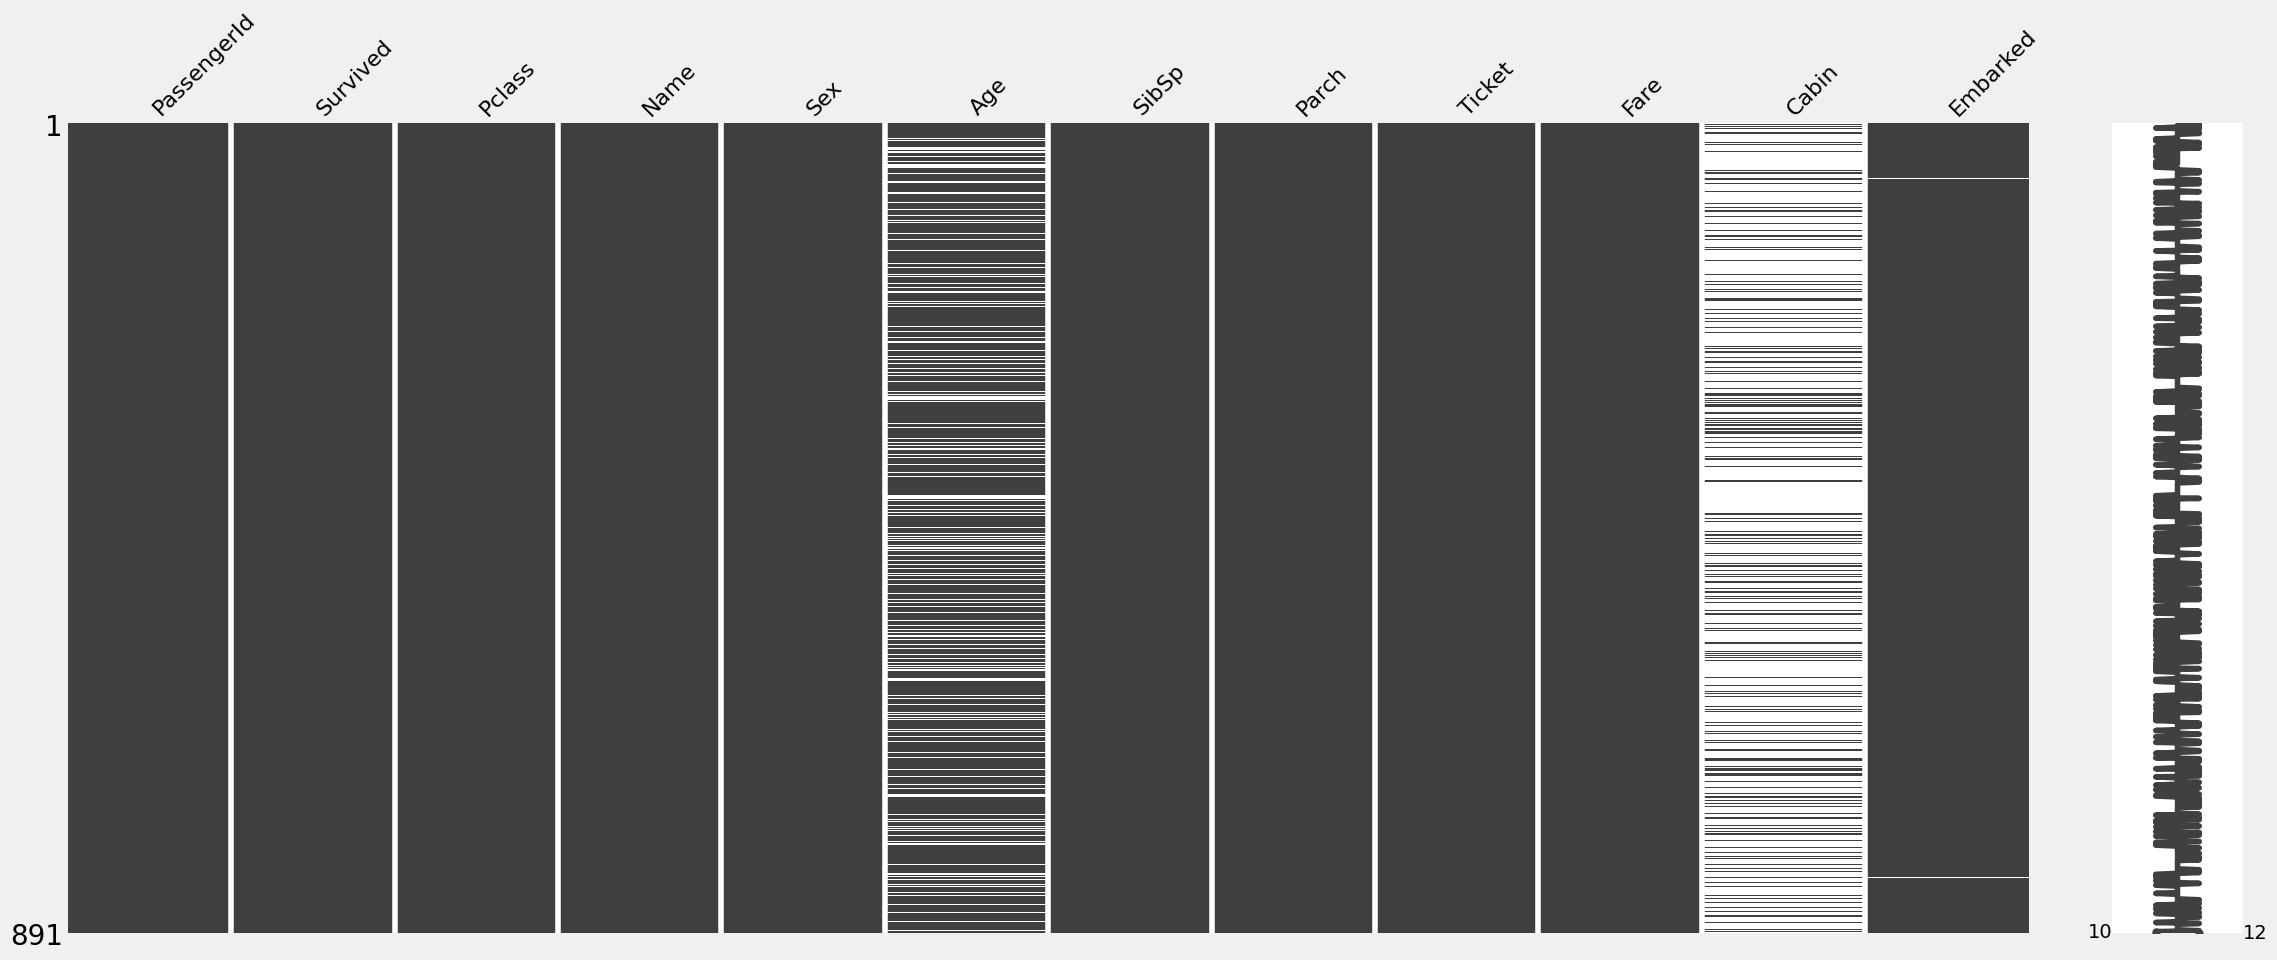

In [17]:
## Plot graphic of missing values
msno.matrix(train)

In [18]:
## Summarizing the missing values per column

train.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


# To perform our data analysis, let's create two new dataframes
We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.

In [19]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

# Function to create count and distribution visualisations

In [20]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column],
                     kde_kws={"label": "Survived","bw":0.1});
        sns.distplot(data.loc[data[label_column] == 0][target_column],
                     kde_kws={"label": "Did not survive","bw":0.1});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column],
                     kde_kws={"label": "Survived","bw":0.1});
        sns.distplot(data.loc[data[label_column] == 0][target_column],
                     kde_kws={"label": "Did not survive","bw":0.1});

# Target Feature: Survived
---
Description: Whether the passenger survived or not.

Key: 0 = did not survive, 1 = survived

This is the variable we want our machine learning model to predict based off all the others.

,count
Survived,
0,549
1,342


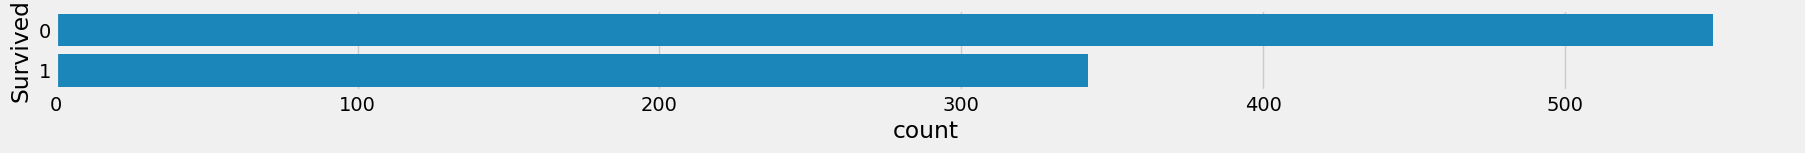

In [21]:
# How many people survived?
fig = plt.figure(figsize=(20,1))
sns.countplot(data=train,y='Survived')
train['Survived'].value_counts()

In [22]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

# Feature: Pclass
---
Description: The ticket class of the passenger.

Key: 1 = 1st, 2 = 2nd, 3 = 3rd

<Axes: xlabel='Pclass', ylabel='Density'>

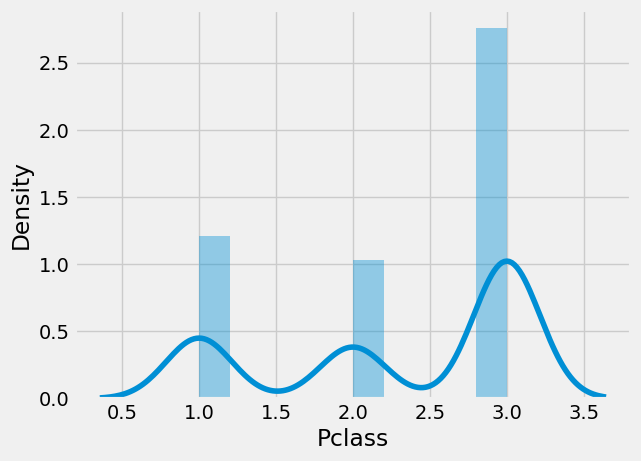

In [23]:
# Let's plot the distribution
sns.distplot(train['Pclass'])

In [24]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

# Feature: Name
Description: The name of the passenger.

In [25]:
train['Name'].value_counts()

,count
Name,
"Dooley, Mr. Patrick",1
"Braund, Mr. Owen Harris",1
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1
"Heikkinen, Miss. Laina",1
"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
...,...
"Hewlett, Mrs. (Mary D Kingcome)",1
"Vestrom, Miss. Hulda Amanda Adolfina",1
"Andersson, Mr. Anders Johan",1


# Feature: Sex
Description: The sex of the passenger (male or female).

,count
Sex,
male,577
female,314


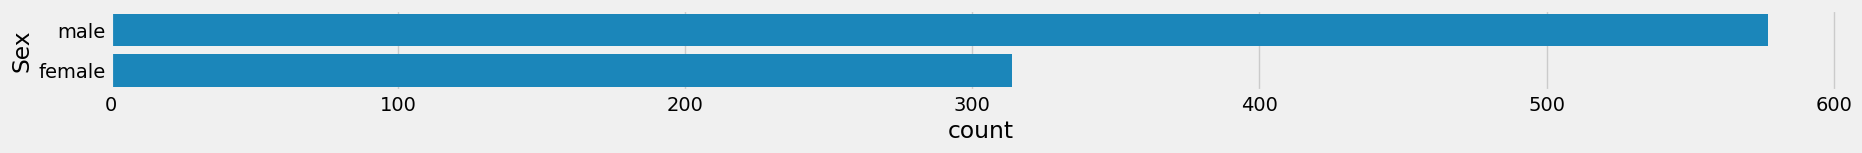

In [26]:
# Distribution of males and females

fig = plt.figure(figsize=(20,1))
sns.countplot(data=train,y='Sex')
train['Sex'].value_counts()

In [27]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']

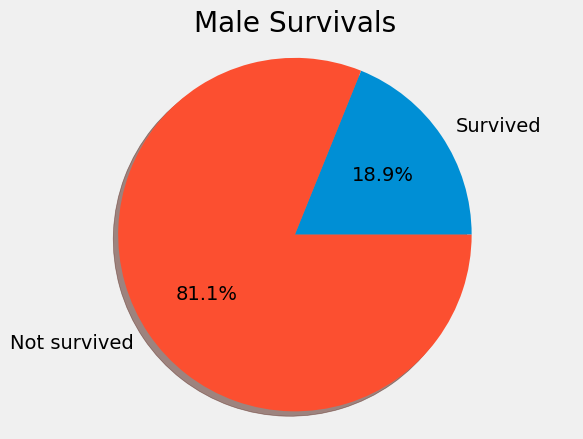

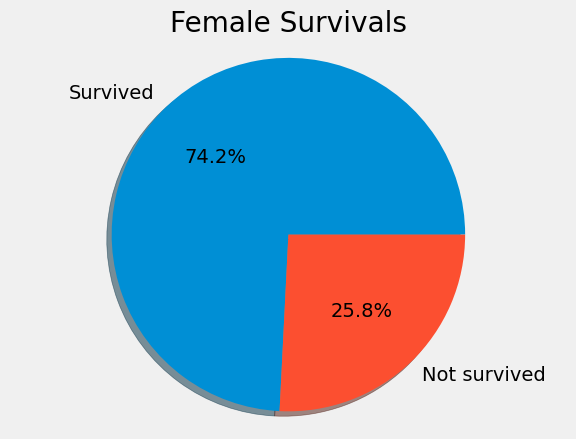

In [28]:
# How does the Sex variable look compared to Survival?

# pie chart for male and female survivors
labels = ['Survived', 'Not survived']
male_sizes = [train[(train['Sex']=='male')&(train['Survived']==1)].count()[0],train[(train['Sex']=='male')&(train['Survived']==0)].count()[0]]
female_sizes = [train[(train['Sex']=='female')&(train['Survived']==1)].count()[0],train[(train['Sex']=='female')&(train['Survived']==0)].count()[0]]

# print(sizes) # adds up to 1433, which is the total number of participants
fig1, ax1 = plt.subplots()
ax1.pie(male_sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title('Male Survivals')
plt.show()

fig2, ax2 = plt.subplots()
ax2.pie(female_sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax2.axis('equal')
plt.title('Female Survivals')
plt.show()

# Feature: Age
Description: The age of the passenger.

In [29]:
# Find missing values
train['Age'].isnull().sum()

np.int64(177)

# Feature: SibSp
Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [30]:
train['SibSp'].value_counts()

,count
SibSp,
0,608
1,209
2,28
4,18
3,16
8,7
5,5


In [31]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

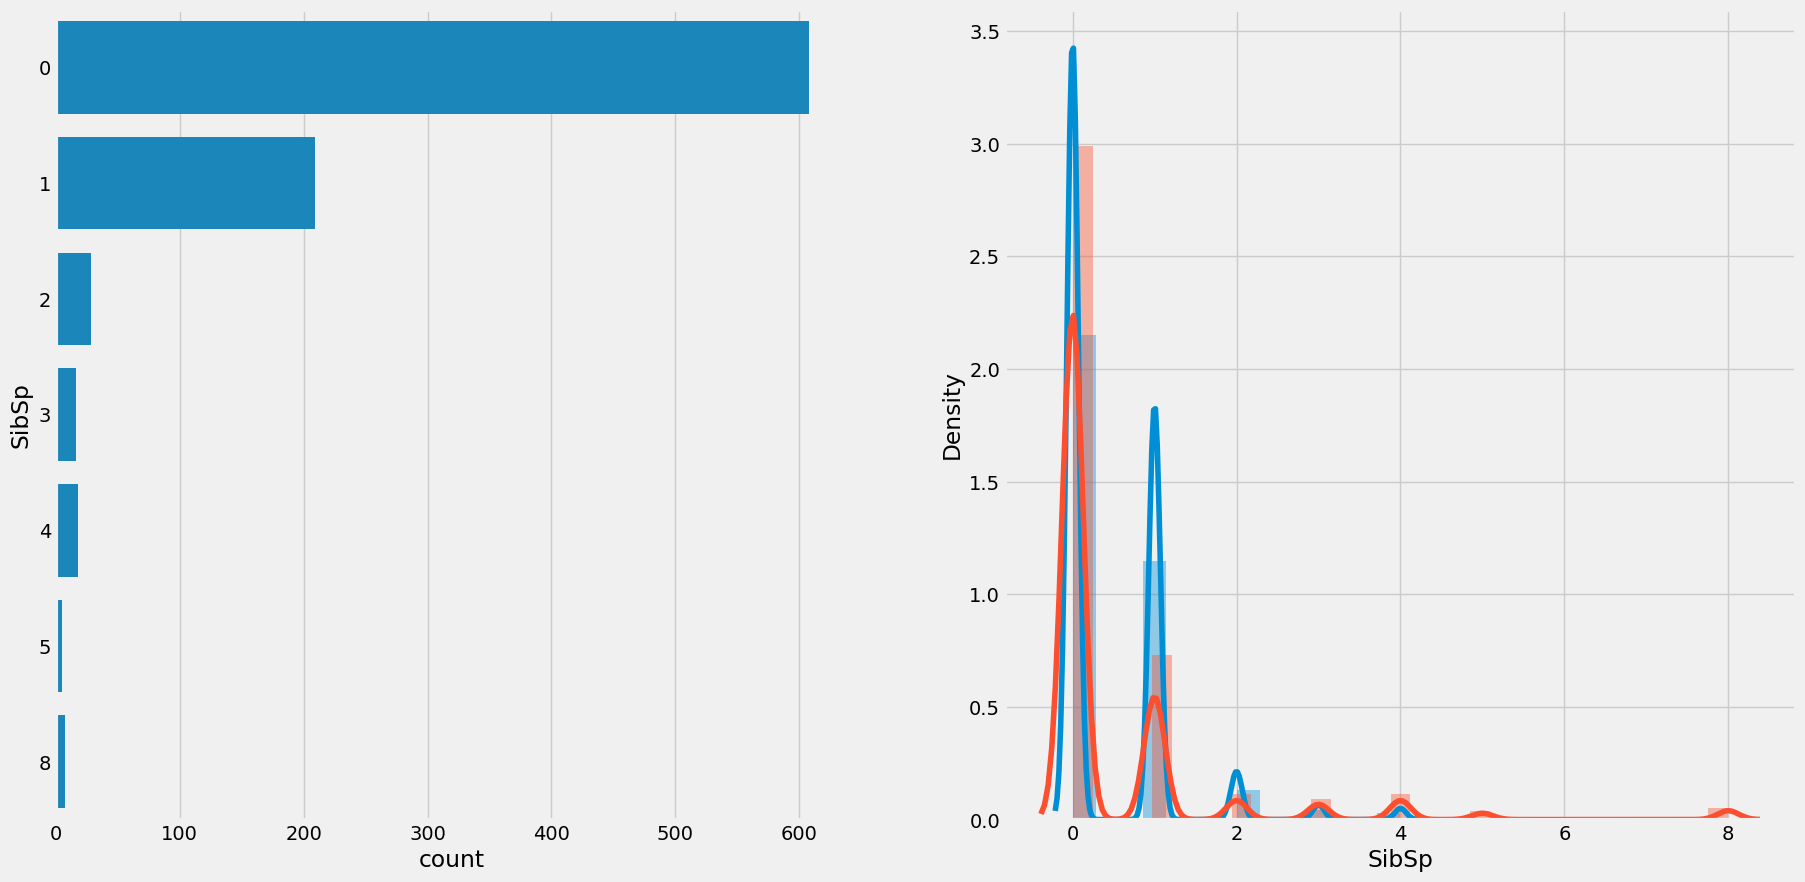

In [32]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train,
                bin_df=df_bin,
                label_column='Survived',
                target_column='SibSp',
                figsize=(20, 10))

# Feature: Parch
Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.

In [33]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

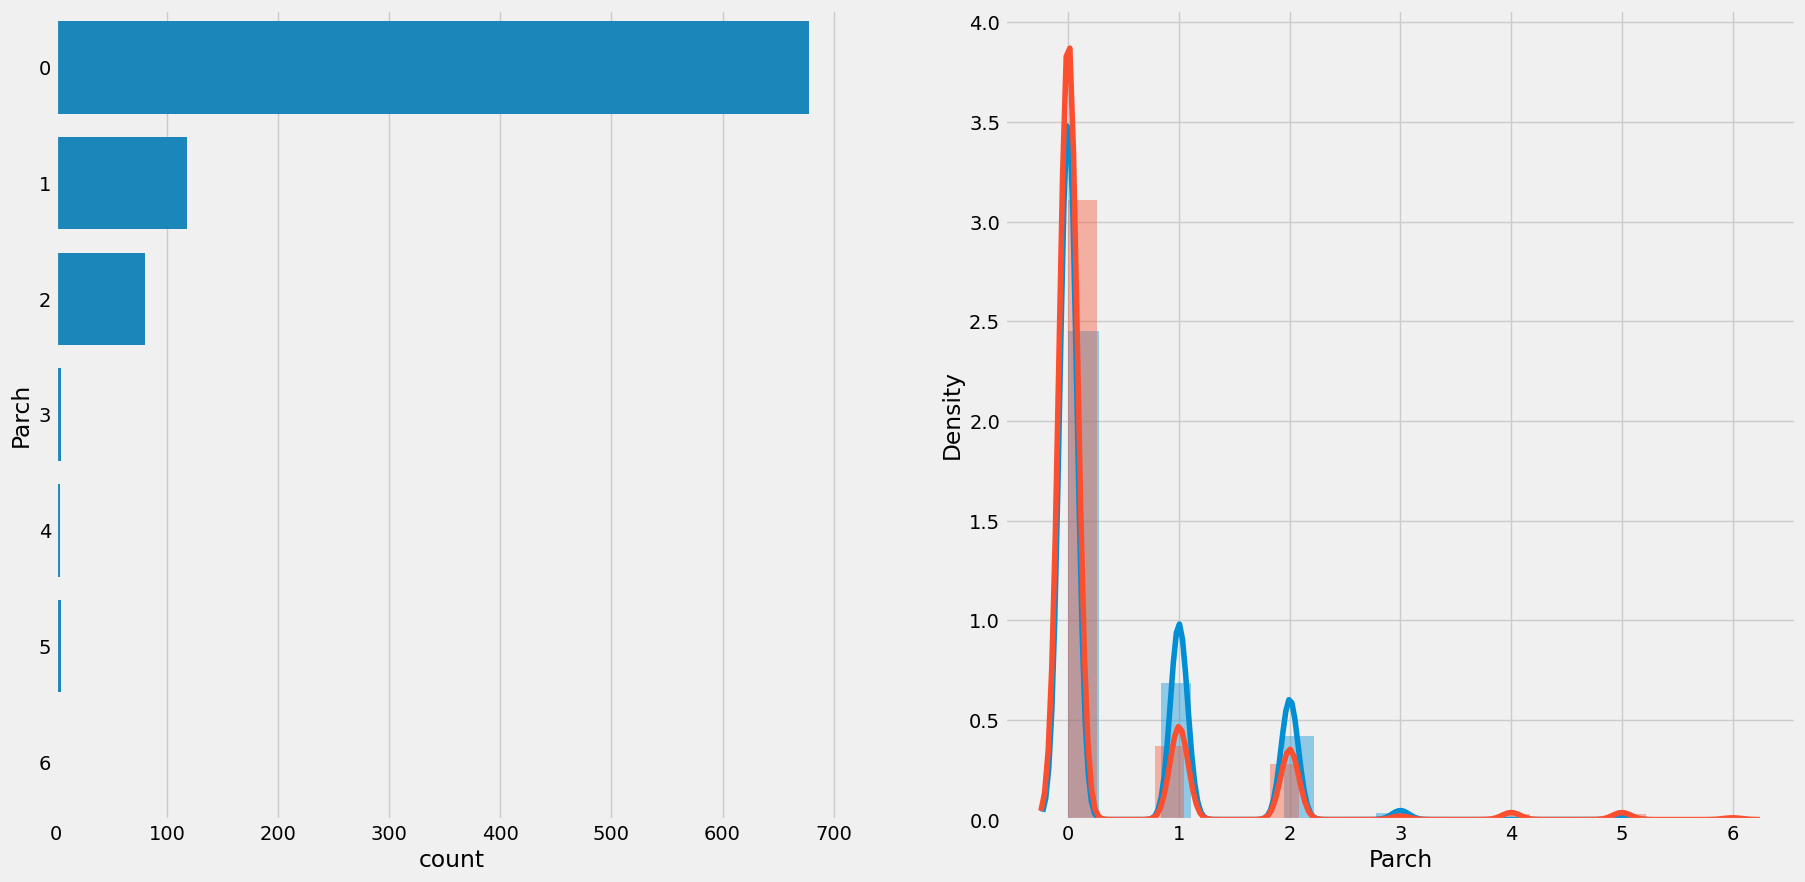

In [34]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train,
                bin_df=df_bin,
                label_column='Survived',
                target_column='Parch',
                figsize=(20, 10))

# Feature: Fare
Description: How much the ticket cost.

In [35]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare']
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised

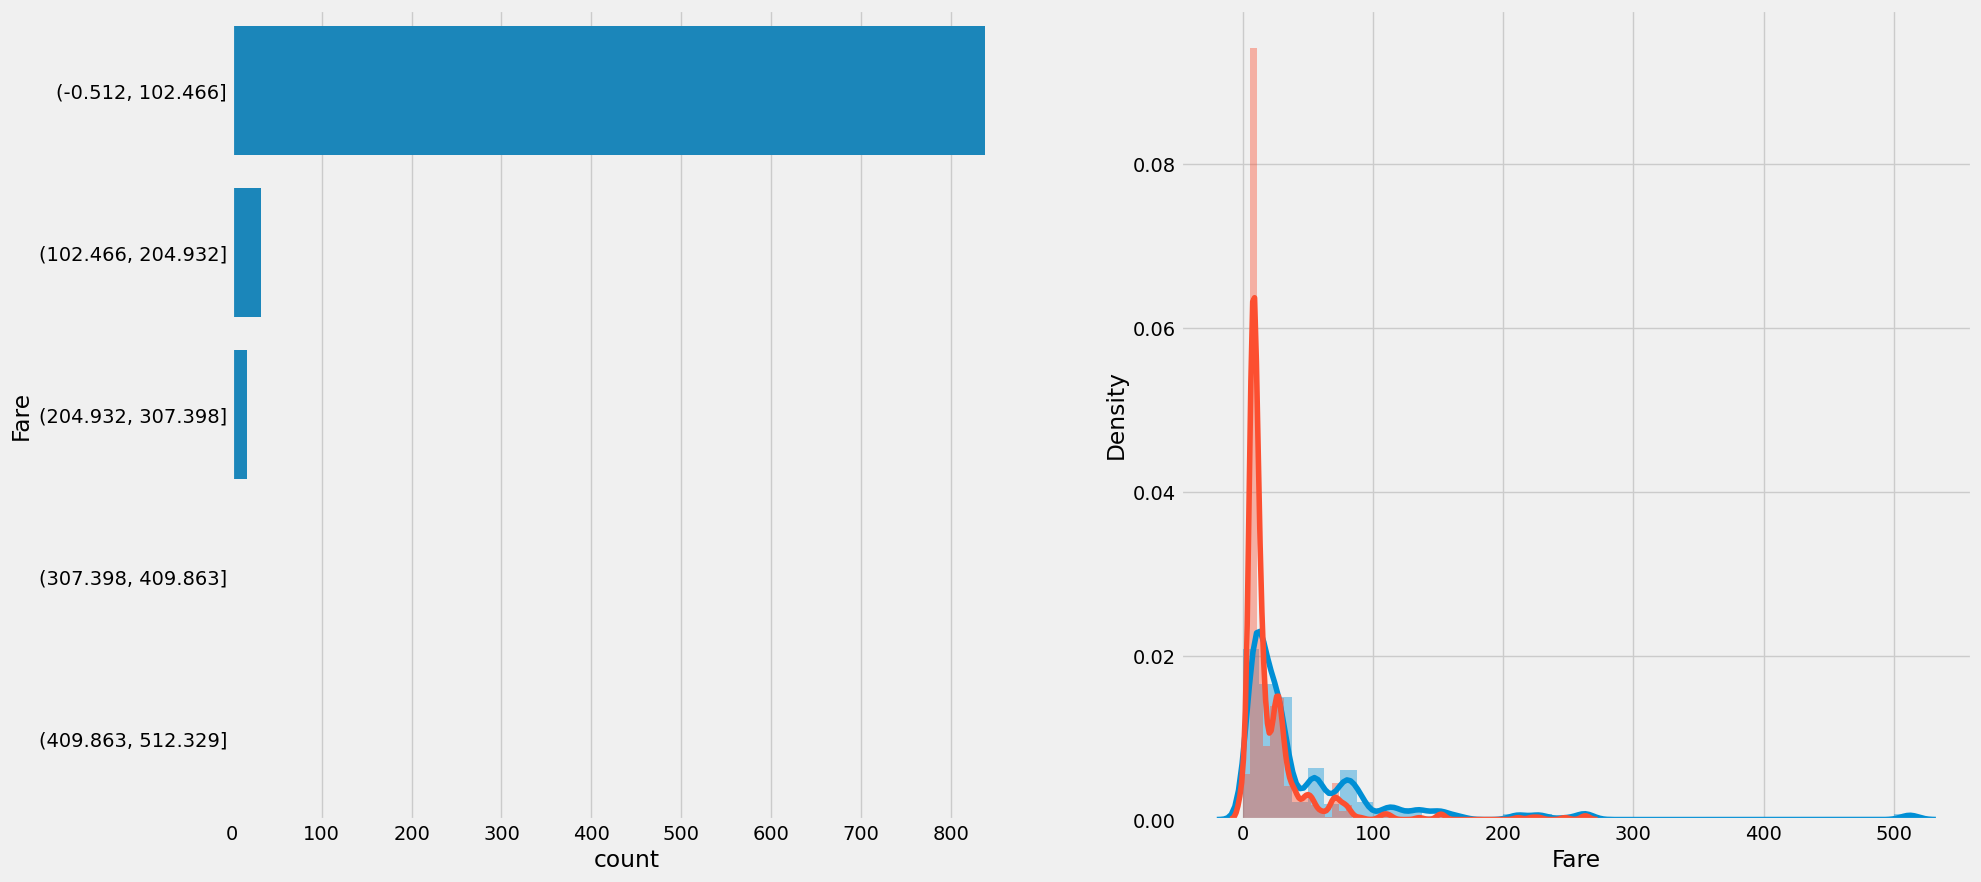

In [36]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived',
                target_column='Fare',
                figsize=(20,10),
                use_bin_df=True)

In [37]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,0,1,0,"(-0.512, 102.466]"
1,1,1,1,1,0,"(-0.512, 102.466]"
2,1,3,1,0,0,"(-0.512, 102.466]"
3,1,1,1,1,0,"(-0.512, 102.466]"
4,0,3,0,0,0,"(-0.512, 102.466]"


In [38]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,male,1,0,7.2500
1,1,1,female,1,0,71.2833
2,1,3,female,0,0,7.9250
3,1,1,female,1,0,53.1000
4,0,3,male,0,0,8.0500


# Feature: Embarked
Description: The port where the passenger boarded the Titanic.

Key: C = Cherbourg, Q = Queenstown, S = Southampton

<Axes: xlabel='count', ylabel='Embarked'>

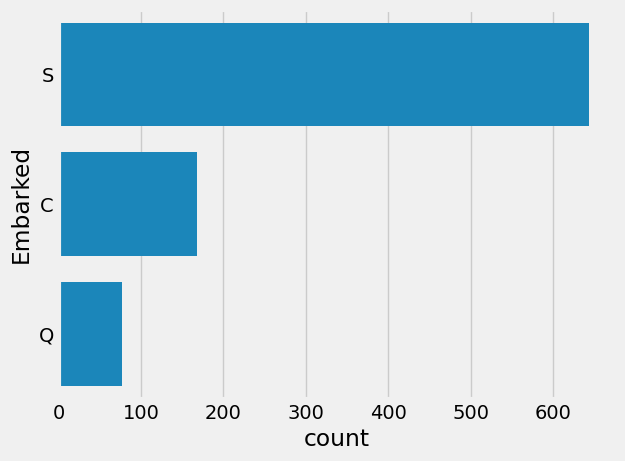

In [39]:
# Visualise the Embarking Ports
sns.countplot(y='Embarked',data=train)

In [40]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [41]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


# Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

Encoding our binned dataframe (df_bin) with one-hot encoding and our continuous dataframe (df_con) with the label encoding function from sklearn

In [42]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [43]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [44]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,False,False,True,True,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True
1,1,True,False,False,False,True,False,True,False,False,...,False,False,True,False,False,False,False,True,False,False
2,1,False,False,True,False,True,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
3,1,True,False,False,False,True,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True
4,0,False,False,True,True,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True


In [45]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'],
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'],
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'],
                                   prefix='pclass')

In [46]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con,
                        df_embarked_one_hot,
                        df_sex_one_hot,
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [47]:
# Let's look at df_con_enc
df_con_enc.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,False,False,True,False,True,False,False,True
1,1,1,0,71.2833,True,False,False,True,False,True,False,False
2,1,0,0,7.9250,False,False,True,True,False,False,False,True
3,1,1,0,53.1000,False,False,True,True,False,True,False,False
4,0,0,0,8.0500,False,False,True,False,True,False,False,True


# Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

In [48]:
# Split the dataframe into data and labels
X_train = df_con_enc.drop('Survived', axis=1) # data
y_train = df_con_enc.Survived # labels

# Define a function to fit machine learning algorithms

In [49]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):

    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)

    # Cross Validation
    train_pred = model_selection.cross_val_predict(algo,
                                                  X_train,
                                                  y_train,
                                                  cv=cv,
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

    return train_pred, acc, acc_cv

# Logistic Regression

In [50]:
# Logistic Regression

train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(),
                                                               X_train,
                                                               y_train,
                                                                    10)

print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42


# K-Nearest Neighbours

In [51]:
# k-Nearest Neighbours

train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(),
                                                  X_train,
                                                  y_train,
                                                  10)

print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)

Accuracy: 83.58
Accuracy CV 10-Fold: 77.39


# Gaussian Naive Bayes

In [52]:
# Gaussian Naive Bayes

train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(),
                                                                      X_train,
                                                                      y_train,
                                                                           10)

print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)

Accuracy: 78.52
Accuracy CV 10-Fold: 77.95


# Linear SVC

In [53]:
# Linear SVC

train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train,
                                                                y_train,
                                                                10)

print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)

Accuracy: 79.75
Accuracy CV 10-Fold: 79.3


# Stochastic Gradient Descent

In [54]:
# Stochastic Gradient Descent

train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(),
                                                  X_train,
                                                  y_train,
                                                  10)

print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)

Accuracy: 61.75
Accuracy CV 10-Fold: 68.05


# Decision Tree Classifier

In [55]:
# Decision Tree Classifier

train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(),
                                                                X_train,
                                                                y_train,
                                                                10)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)

Accuracy: 92.46
Accuracy CV 10-Fold: 80.76


# Gradient Boost Trees

In [56]:
# Gradient Boost Trees
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(),
                                                                       X_train,
                                                                       y_train,
                                                                       10)

print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)

Accuracy: 86.61
Accuracy CV 10-Fold: 80.65


# CatBoost

In [58]:
# Define the categorical features for the CatBoost model
# cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features = np.where(X_train.dtypes != float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10])

In [59]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train,
                  y_train,
                  cat_features)

In [60]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6862830	total: 49.4ms	remaining: 49.3s
1:	learn: 0.6809444	total: 51.4ms	remaining: 25.6s
2:	learn: 0.6751692	total: 53.6ms	remaining: 17.8s
3:	learn: 0.6689060	total: 55.8ms	remaining: 13.9s
4:	learn: 0.6632144	total: 58.1ms	remaining: 11.6s
5:	learn: 0.6576488	total: 59.9ms	remaining: 9.93s
6:	learn: 0.6544441	total: 61.1ms	remaining: 8.67s
7:	learn: 0.6490635	total: 63.3ms	remaining: 7.84s
8:	learn: 0.6443241	total: 65.5ms	remaining: 7.21s
9:	learn: 0.6395935	total: 67.8ms	remaining: 6.72s
10:	learn: 0.6345186	total: 69.6ms	remaining: 6.26s
11:	learn: 0.6305316	total: 71.8ms	remaining: 5.91s
12:	learn: 0.6275610	total: 73.1ms	remaining: 5.55s
13:	learn: 0.6225020	total: 75.2ms	remaining: 5.3s
14:	learn: 0.6179503	total: 77.4ms	remaining: 5.08s
15:	learn: 0.6140480	total: 78.7ms	remaining: 4.84s
16:	learn: 0.6100034	total: 80.4ms	remaining: 4.65s
17:	learn: 0.6049646	total: 82.6ms	remaining: 4.5s
18:	learn: 0.6025760	total: 83.7ms	remaining: 

In [63]:
# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)


# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
24:	learn: 0.4893301	test: 0.4638872	best: 0.4638872 (24)	total: 147ms	remaining: 5.74s
25:	learn: 0.4846609	test: 0.4581783	best: 0.4581783 (25)	total: 149ms	remaining: 5.6s
26:	learn: 0.4812979	test: 0.4546720	best: 0.4546720 (26)	total: 152ms	remaining: 5.47s
27:	learn: 0.4773794	test: 0.4509130	best: 0.4509130 (27)	total: 154ms	remaining: 5.34s
28:	learn: 0.4759959	test: 0.4490016	best: 0.4490016 (28)	total: 155ms	remaining: 5.2s
29:	learn: 0.4726830	test: 0.4445672	best: 0.4445672 (29)	total: 158ms	remaining: 5.1s
30:	learn: 0.4686808	test: 0.4400542	best: 0.4400542 (30)	total: 160ms	remaining: 5s
31:	learn: 0.4656687	test: 0.4373876	best: 0.4373876 (31)	total: 162ms	remaining: 4.91s
32:	learn: 0.4629759	test: 0.4342703	best: 0.4342703 (32)	total: 164ms	remaining: 4.82s
33:	learn: 0.4619416	test: 0.4328279	best: 0.4328279 (33)	total: 167ms	remaining: 4.74s
34:	learn: 0.4610411	test: 0.4314925	best: 0.4314925 (34)	total: 168ms	rema

In [64]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))

---CatBoost Metrics---
Accuracy: 83.91
Accuracy cross-validation 10-Fold: 81.32


# Model Results

In [65]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes',
              'Stochastic Gradient Decent', 'Linear SVC',
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn,
        acc_log,
        acc_gaussian,
        acc_sgd,
        acc_linear_svc,
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.46
6,Gradient Boosting Trees,86.61
7,CatBoost,83.91
0,KNN,83.58
1,Logistic Regression,79.98
4,Linear SVC,79.75
2,Naive Bayes,78.52
3,Stochastic Gradient Decent,61.75


In [66]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes',
              'Stochastic Gradient Decent', 'Linear SVC',
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn,
        acc_cv_log,
        acc_cv_gaussian,
        acc_cv_sgd,
        acc_cv_linear_svc,
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,81.32
5,Decision Tree,80.76
6,Gradient Boosting Trees,80.65
1,Logistic Regression,79.42
4,Linear SVC,79.30
2,Naive Bayes,77.95
0,KNN,77.39
3,Stochastic Gradient Decent,68.05


# Feature Importance

In [67]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png')

,imp,col
4,0.992061,embarked_Q
3,1.213711,embarked_C
5,1.677219,embarked_S
9,2.178083,pclass_2
8,3.243021,pclass_1
0,10.797435,SibSp
10,11.205450,pclass_3
1,13.988886,Parch
2,15.753218,Fare
6,17.695520,sex_female


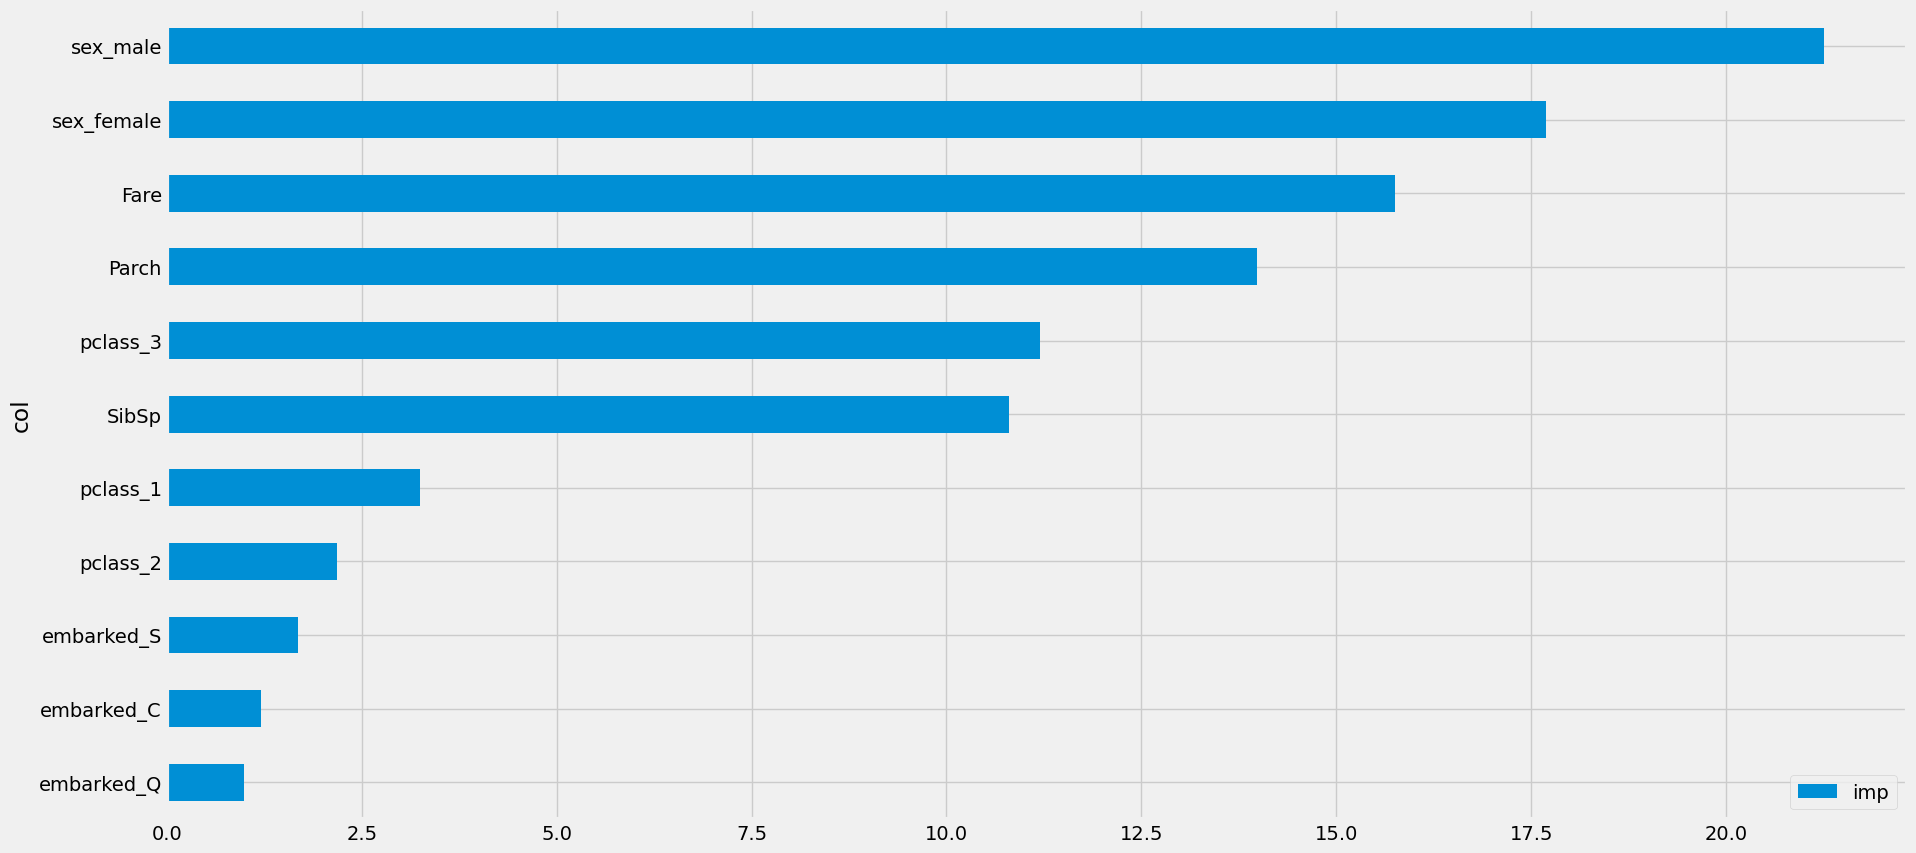

In [68]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

# Precision & Recall

In [69]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8286662683284687
Recall: 0.6833382352941176
F1: 0.7489789466084935
AUC: 0.8842839467480982


# Submission

In [70]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,False,False,True,False,True,False,False,True
1,1,0,71.2833,True,False,False,True,False,True,False,False
2,0,0,7.9250,False,False,True,True,False,False,False,True
3,1,0,53.1000,False,False,True,True,False,True,False,False
4,0,0,8.0500,False,False,True,False,True,False,False,True


In [71]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [72]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'],
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'],
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'],
                                   prefix='pclass')

In [73]:
# Combine the test one hot encoded columns with test
test = pd.concat([test,
                  test_embarked_one_hot,
                  test_sex_one_hot,
                  test_plcass_one_hot], axis=1)

In [74]:
# Let's look at test, it should have one hot encoded columns now
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,False,True,False,False,True,False,False,True
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,False,False,True,True,False,False,False,True
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,False,True,False,False,True,False,True,False
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,False,False,True,False,True,False,False,True
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,False,False,True,True,False,False,False,True


In [75]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [76]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns])

In [77]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [78]:
# What does our submission have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [79]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [80]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [81]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [ ]:
# # Convert submisison dataframe to csv for submission to csv
# # for Kaggle submisison
# submission.to_csv('catboost_submission.csv', index=False)
# print('Submission CSV is ready!')